The goal of this notebook is to test out using pretrained models and apply neural style transfer techniques. We will get the style layers from the VGG19 network since VGG is known to work well for style.  We will start by using VGG19 for content as well for simplicity, and perhaps change content networks later. 

This code is heavily influenced by the deeplearning.ai coursera specialization and the transfer learning tutorial provided by tensorflow.  Unlike the deeplearning.ai code, I will use keras, and precompute the style Gram matrices rather than computing them every cycle.

Some of the images used in testing this were taken fairly randomly from the internet, and have therefore not been included in the project (noteably 'table.jpeg' and 'beach.jpeg').  If running this code on a different computer, use any other images and change the file names in the code respectively.

In [ ]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from scipy.misc import imsave
import tensorflow.contrib.eager as tfe
import matplotlib.pyplot as plt
import os
import platform
if(platform.system() == 'Darwin' and platform.release()[:2] == '17'):
    print("This version of macOS crashes when using both matplotlib and keras, \
so we enable an os flag as a workaround.")
    os.environ['KMP_DUPLICATE_LIB_OK']='True' # Workaround to remove crash for my macOS version
tf.enable_eager_execution()

First lets load the VGG19 network and try it out on a few examples.  If running this notebook elsewhere, it may be necessary to download a few random images and change the image names in this notebook appropriately.

In [ ]:
imagemodel = keras.applications.VGG19(weights='imagenet',include_top=True)
# We must set each layer to be untrainable individually
for layer in imagemodel.layers:
    layer.trainable = False
imagemodel.summary()

We define functions to load and preprocess an image, predict the label for an image, and to graph the top 5 predictions.

In [ ]:
def retrieve_image(imgpath):
    """Load the an image by its path and preprocess it to run through VGG"""
    image = load_img(imgpath,target_size=(224,224))
    image = img_to_array(image)
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image = preprocess_input(image)
    return image

In [ ]:
def image_guesses(image):
    """Return two lists containing the labels and probabilities for the most likely (up to 5) contents of an image"""
    yhat = imagemodel.predict(image)
    preds = decode_predictions(yhat)[0][:5] # Restrict to at most 5 predictions.
    prediction_labels = [pred[1] for pred in preds]
    prediction_probs = [pred[2] for pred in preds]
    return prediction_labels, prediction_probs
    

In [ ]:
def display_predictions(prediction_labels, prediction_probs, subplotloc = 111):
    """Display a pyplot graph showing the top predictions and their probabilities for an image.
    
    Args:
        prediction_names : a list of strings giving the names of the top predictions
        prediction_probs : a list of probabilities (summing to at most 1) giving the associated probabilities
        subplotloc : A tuple or integer to be passed to plt.subplot().  The default takes up the full figure.
        
        We assume 0 < len(prediction_names) == len(prediction_probs)
    """
    pred_count = len(prediction_labels)
    if(pred_count != len(prediction_probs)):
        print("Error: Prediction label and probability vector have different lengths.")
        return
    plt.subplot(subplotloc)
    plt.bar(range(pred_count), prediction_probs)
    _ = plt.xticks(range(pred_count), prediction_labels)
    

We test our functions by evaluating on a couple of sample images

In [ ]:
prediction_labels, prediction_probs = image_guesses(retrieve_image("table.jpeg"))

In [ ]:
display_predictions(prediction_labels, prediction_probs)

In [ ]:
display_predictions(*image_guesses(retrieve_image("beach.jpeg")))

It works!  Now lets prepare for the neural style transfer.  Initially we choose our style and content layers based off of the transfer learning tensorflow tutorial.  We can later update to optimize for better results.

In [ ]:
def noisy_image(image):
    """Adds noise to an image in VGG input array format."""
    
    noise_mask = np.random.uniform(-20, 20, image.shape).astype('float32')
    noisy_image = .5 * (image + noise_mask)
    return noisy_image

In [ ]:
def deprocess_image(processed_img):
    """Converts image in VGG input format to a normal image.
    Code from Google's NST tensorflow tutorial.  See reference/license at the bottom.
    
    """
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                               "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
      raise ValueError("Invalid input to deprocessing image")
  
    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- content cost
    """
    
    # compute the cost with tensorflow
    # we do not bother scaling
    J_content = tf.divide(tf.reduce_sum(tf.square(a_C-a_G)), 4. * tf.size(a_C, out_type=tf.float32) ** 2)
    
    return J_content

In [ ]:
def gram_matrix(A):
    """Compute the Gram (autocorrelation) matrix of A.

    Argument:
    A -- matrix of shape (1, n_H, n_W, n_C)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    # Reshape to [n_H*n_W, n_C]
    n_C = A.get_shape()[-1]
    A_unrolled = tf.reshape(A,[-1,n_C]) 
    # Compute Gram matrix
    GA = tf.matmul(A_unrolled,A_unrolled,transpose_a=True)
    return GA

In [ ]:
def compute_layer_style_cost(a_G, GS):
    """
    Arguments:
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    GS -- Gram matrix of the style image corresponding to the same layer
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # Compute Gram matrix for G
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = tf.divide(tf.reduce_sum(tf.square(GS-GG)),(4. * tf.size(GG, out_type=tf.float32) ** 2))
    
    return J_style_layer

In [ ]:
def all_cost(model, image, content_outputs, style_gram_matrices, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    model -- keras image model
    image -- preprocessed image to apply model to
    content_outputs -- outputs of the content layers from the content image
    style_gram_matrices -- precomputed Gram matrices from the style outputs of the style image
    alpha -- content loss weight
    beta -- style loss weight
    
    Returns:
    total cost -- weighted sum of the content and style costs
    content_cost
    style_cost
    """
    outputs = model(image)
    base_content = outputs[:len(content_outputs)]
    base_style = outputs[len(content_outputs):]
    
    # Take average content and style cost over all content/style layers
    content_cost = sum(compute_content_cost(a,b) for a,b in zip(base_content,content_outputs))
    style_cost = sum(compute_layer_style_cost(a,b) for a,b in zip(base_style,style_gram_matrices))
    total_cost = alpha*content_cost + beta*style_cost
    
    return total_cost, content_cost, style_cost

We now precompute the style and content outputs of the style and content image respectively.

In [ ]:
content_image = retrieve_image("ellie.JPG")
style_image = retrieve_image("picasso.jpg")

In [ ]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]
style_outputs = [imagemodel.get_layer(name).output for name in style_layers]
content_outputs = [imagemodel.get_layer(name).output for name in content_layers]
model_outputs = content_outputs + style_outputs
model = keras.models.Model(inputs = imagemodel.inputs, outputs = model_outputs)

In [ ]:
model.summary()

In [ ]:
def NST(content_image, style_image, num_iterations, base_image = None):
    """Apply Neural style transfer to a randomized version of the content image to 
    produce an image in the style of the style image
    """
    #content_image = retrieve_image(content_image_name)
    #style_image = retrieve_image(style_image_name)
    
    content_outputs = model(content_image)[:len(content_layers)]
    style_outputs = model(style_image)[len(content_layers):]
    style_gram_matrices = [gram_matrix(A) for A in style_outputs]
    if not base_image:
        base_image = noisy_image(content_image)
    base_image = tfe.Variable(base_image, dtype=tf.float32)
    opt = tf.train.AdamOptimizer(learning_rate=5.)
    
    imgs = []
        
    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            loss, content_loss, style_loss = all_cost(model, base_image, content_outputs, style_gram_matrices)
        grads = tape.gradient(loss, base_image)
        opt.apply_gradients([(grads, base_image)])
        
        if i % 20 == 0: # Maybe increase if run on GPU but for now we can print every time.
            imgs.append(deprocess_image(base_image.numpy()))
            print('Iteration {}, loss {:.2f}, content loss {:.2f}, style loss {:.2f}'.format(i,loss, content_loss, style_loss))
        else:
            print('.',end='')
    else:
        #Final image
        imgs.append(deprocess_image(base_image.numpy()))
    return imgs

We can now run the neural style transfer and display the results.  The images are stored in the res variable every 20 iterations and can be saved to disk afterwards using, for example, scypi.misc.imsave(arr=res[i],name='filename')

In [ ]:
res = NST(content_image, style_image, num_iterations=160)

In [ ]:
_, ax = plt.subplots(3,3, figsize=(10,10))
for i, img in enumerate(res):
    ax[i % 3, i // 3].imshow(img)

I apply this to Ellie (my parents' dog) to get some neat images.

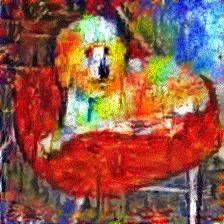

Portions of this page (specifically, the deprocess_image function) are reproduced from work created and shared by Google and licensed under the Apache 2.0 License.